# Model quality assesment

When building a statistical model, a typical question that may raise is "how does my model compare to another one?", or put in another way, "How to assess the quality of my model?". Such question is crucial when it comes to choose hyperparameters values (e.g., amount of POIs vs numbers of projection dimension) or to see if a bigger training complexity can lead to substancial improvement of the attack taking into account the time and memory complexity of one evaluator's setup. in this Section, we will try to tackle the issue following two different approach: the information theory metric computation and the rank estimation. 

## Information Theory Metric 

Information Theory (IT) metric can help us to evaluate the quality of a model. In particular, the Mutual Information (MI) between a sensitive intermediate variable and the practical leakage can be used to link the attack data complexity to its success rate, as detailed in Section 3.2.1 of the book. Intuitively, the more the leakage contains information about the targeted intermediate variable, the less traces are required to succeed. The MI is computed as follows:

$$\mathsf{MI}(V; \boldsymbol{L}) = \mathsf{H}(V) + \sum_{v\in V} \mathsf{Pr}(v)\cdot \int_{l\in L}\mathsf{f}(\boldsymbol{l}|v)\cdot \mathsf{log}_2\mathsf{Pr}(v|\boldsymbol{l})dl$$

where $\mathsf{H}(V)$ is the entropy of $V$ and $\mathsf{Pr}(v|\boldsymbol{l})$ can be computed thanks to Bayes law. However, as pointed out in Section 3.3.1, evaluating the exact MI turns out to be difficult since the true distribution of the leakage is unknown. Alternatively, we can estimate the amount of information that can be extracted from a given model using the Perceived Information (PI) and compare different models by comparing their PIs. PI is defined similarly to the MI with the difference that the value depending on the true leakage distribution are estimated, leading to its approximation given by 

$$\tilde{\mathsf{PI}}(V; \boldsymbol{L}) = \mathsf{H}(V) + \sum_{v\in V} \mathsf{Pr}(v) \cdot \sum_{\boldsymbol{l}\in \mathcal{L}_{t}(v)} \dfrac{1}{\left| \mathcal{L}_t(v) \right|} \cdot \mathsf{log}_2 \hat{\mathsf{Pr}}(v|\boldsymbol{l}) dl$$

where the hat notation is used to reflect the (potentially imperfect) estimation of the model, the tilde notation is used to reflect the estimation of the PI metric based on a set of test samples $\mathcal{L}_{\mathsf{t}}$, which is different from the set $\mathcal{L}_{\mathsf{p}}$ used for profiling.

Next, you first have to implement the following function that compute the $\mathsf{PI}$. 

- *hint: The entropy of a uniformly distributed variable of n-bits equals n*

In [1]:
import numpy as np
def compute_PI(labels, log2prob):
    """
    labels: for each traces, the correct labels associated to each variables, as an arrya of shape (ntraces, nvars)
    log2prob: for each variable, for each each traces, the log-probability of each class as an array of shape (nvars, ntraces, 256)

    returns: (pis, lprobs) where:
        pis: for each variable, the PI value computed, as an arrya of shape (nvars, )
        lprobs: for each variables, the lprob used in the pis computation for each trace (nvars, test_ntraces)
    """
    ###ANSWER_START
    pis = np.zeros(labels.shape[1])
    lprobs = np.zeros([labels.shape[1], labels.shape[0]])
    for vi in range(labels.shape[1]):
        lprobs[vi,:] = log2prob[vi, np.arange(labels.shape[0]), labels[:,vi]]
        pis[vi] = 8 + np.mean(lprobs[vi,:])
    return pis, lprobs
    ###ANSWER_STOP

Next, we provide you with the following functions for calculating PI for the univariate and multivariate Gaussian templates from the previous session. Feel free to browse through them to understand what's being done. 

In [2]:
from utils_scale import utils_ta
import numpy as np

def univariate_model_log2prob(traces, labels, pois, models):
    """
    traces: the training traces, as an array of shape (ntraces, nsamples).
    labels: for each traces, the correct labels associated to each variables, as an arrya of shape (ntraces, nvars)
    pois: the list of pois to used, as an array of shape (nvars, )
    models: (us, ss) such as 
        us: the models means for each class, as an array of shape (nvars, 256)
        ss: the models stds for each class, as an array of shape (nvars, 256)

    return: for each variable, for each each traces, the log-probability of each class as an array of shape (nvars, ntraces, 256)
    """
    return utils_ta.log2Pr_class(traces[:, pois], models)

def pi_uni_TA(train_trs, train_labels, test_trs, test_labels):
    """
    train_trs: the training traces as an array of shape (train_ntraces, nsamples)
    train_labels: training labels (train_ntraces, nvars)
    test_trs: the training traces as an array of shape (test_ntraces, nsamples)
    test_labels: test labels (test_ntraces, nvars)
    return: (pis, lprobs) where
        - `pis` is a vector of shape (nvars,) containing the PI computed for each variable
        - `lprobas` is a matrix of shape (nvars, test_ntraces) containing the log2 proba used to compute the PI
    """
    # SNR 
    pois = utils_ta.POI_selection_SNR(train_trs, train_labels, 256)
    # Compute the models
    models_uni = utils_ta.univariate_gaussian_models(train_trs, train_labels, pois[:,0])
    # Compute the log2prob
    log2prob = univariate_model_log2prob(test_trs, test_labels, pois[:,0], models_uni)
    # Compute the PI
    return compute_PI(test_labels, log2prob)

In [3]:
from utils_scale import utils_ta
import numpy as np
def multivariate_model_log2prob(traces, labels, models):
    """
    traces: the training traces, as an array of shape (ntraces, nsamples).
    labels: for each traces, the correct labels associated to each variables, as an arrya of shape (ntraces, nvars)
    models: the 'Lda' instance build with 'multivariate_gaussian_models'
    
    return: for each variable, for each each traces, the log-probability of each class as an array of shape (nvars, ntraces, 256)
    """
    return np.log2(models.predict_proba(traces.astype(np.int16)))

def pi_LDA_multi_TA(train_trs, train_labels, test_trs, test_labels, npois, ndim):
    """
    train_trs: the training traces as an array of shape (train_ntraces, nsamples)
    train_labels: training labels (train_ntraces, nvars)
    test_trs: the training traces as an array of shape (test_ntraces, nsamples)
    test_labels: test labels (test_ntraces, nvars)
    npois: amount of pois used by the LDA
    ndim: amount of dimensions of the linear subspace projection. 
    test_labels: test labels (test_ntraces, nvars)
    return: (pis, lprobs) where
        - `pis` is a vector of shape (nvars,) containing the PI computed for each variable
        - `lprobas` is a matrix of shape (nvars, test_ntraces) containing the log2 proba used to compute the PI
    """
    # SNR 
    pois = utils_ta.POI_selection_SNR(train_trs, train_labels, 256)
    # Compute the models
    if npois==1:
        upois = pois[:, :npois][:,np.newaxis]
    else:
        upois = pois[:,:npois]
    models = utils_ta.multivariate_gaussian_models(train_trs, train_labels, upois, ndim)
    # Compute the log2prob
    log2prob = multivariate_model_log2prob(test_trs, test_labels, models)
    # Compute the PI
    return compute_PI(test_labels, log2prob)

The code below is your first tool in this session. Its main function is to calculate and display the PI values obtained as a function of the profiling complexity used to build the univariate and multivariate Gaussian models you manipulated in the previous session. In more detail, it includes the following parameters:

- `qt_s`: a list containing the profiling complexities for which to compute the PI
- `npois`: amount of POIs used to fit the LDA (multivariate template only)
- `ndim`: amount of dimension in the linear subspace (multivariate template only)
- `amount_test_traces`: amount of traces used to estimate the PI.

Try to play with the values of the parameter to see their impact.

In [4]:
import matplotlib.pyplot as plt
from utils_scale import utils_files, utils_aes, test_scale
# TODO: modify here
# MTA LDA parameters 
npois = 2 
ndim = 1 

# Training complexity to consider in the PI plot generation
qt_s = [3500, 4096, 6144, 7168, 8192, 14000]

# Amount of traces to use for the PI estimation
amount_test_traces = 2048 # Amount of traces used for the test


### Do not touch anything from here :)
# Load dataset 
ds = utils_files.load_dataset(utils_files.TRAINING_DS[0],seed_shuffle=0, remove_first=True)

# Compute the labels
pSB = utils_aes.Sbox[ds['pts'] ^ ds['ks']]

# Compute the PI for the univariate model
results_pi_uni = test_scale.compute_pi_estimations(
    ds['traces'][:-amount_test_traces], 
    pSB[:-amount_test_traces], 
    ds['traces'][-amount_test_traces:], 
    pSB[-amount_test_traces:], 
    pi_uni_TA, 
    qt_s
)

# Compute PI for the multivariate model
wrap_pi_LDA_multi_TA = lambda a,b,c,d: pi_LDA_multi_TA(a, b, c, d, npois, ndim)
results_pi_multi = test_scale.compute_pi_estimations(
    ds['traces'][:-amount_test_traces], 
    pSB[:-amount_test_traces], 
    ds['traces'][-amount_test_traces:], 
    pSB[-amount_test_traces:], 
    wrap_pi_LDA_multi_TA, 
    qt_s
)

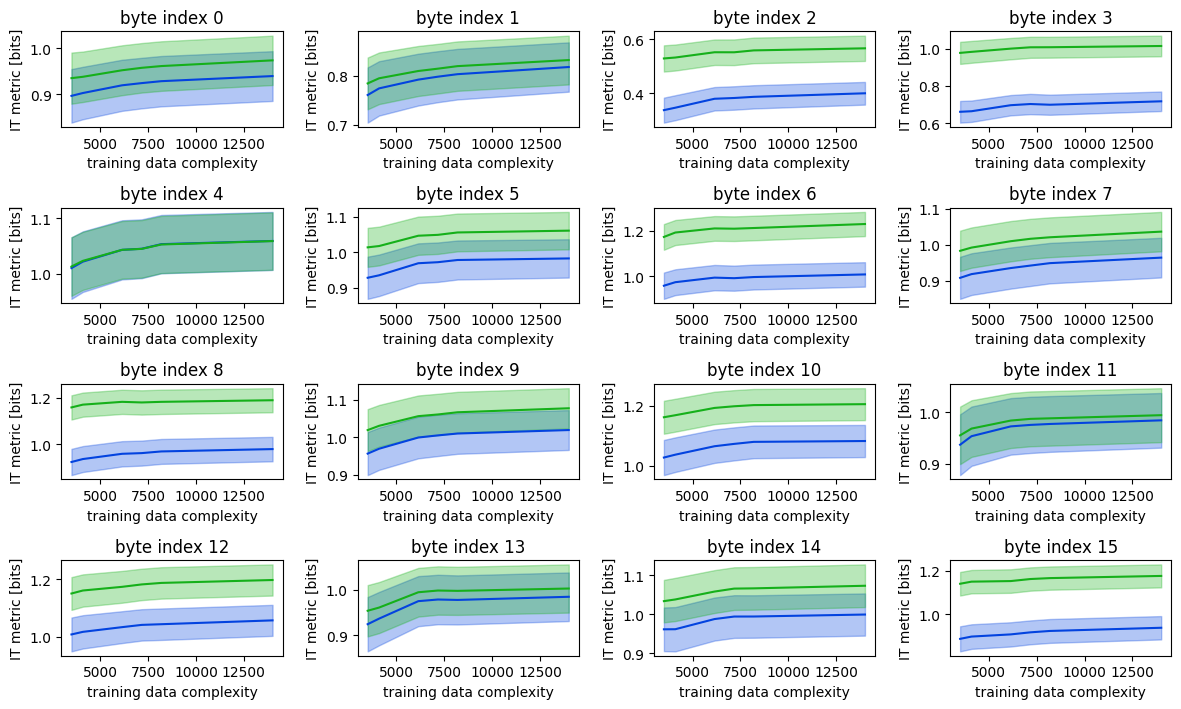

In [5]:
#%matplotlib widget
import matplotlib.pyplot as plt
### Display
byte_indexes= range(16) # Elements in range [0; 15]. Bytes for which display the results.
test_scale.display_IT_results(
    byte_indexes, 
    [
        ("Univariate",results_pi_uni), 
        ("Multivariate", results_pi_multi)
    ],
    scale=0.6,
    disable_legend=True
)

To support the conclusion made in the previous point, a legitimate remaining question is whether the model can be further improved by using a higher profiling complexity than the one used. To this end, it is possible to evaluate the amount of information that remains to be learned by a model, as explained in Section 3.3.1, paragraph *Bounding the learnable information*. In particular, the supremum of the PI can be bounded using the Training Information (TI):

$$\tilde{\mathsf{TI}}(V; \boldsymbol{L}) = \mathsf{H}(V) + \sum_{v\in V}\mathsf{Pr}(v) \cdot \sum_{\boldsymbol{l}\in \mathcal{L}_{\mathsf{p}}(v)} \dfrac{1}{|\mathcal{L}_{\mathsf{p}}(v)|} \cdot \mathsf{log}_{2} \hat{\mathsf{Pr}}(v|\boldsymbol{l}) dl$$

which in fact corresponds to computing the PI over the training set used to build the model in an overfitted manner. Similarly to what you did for the PI, the following function compute the TI for the univariate and the multivariate models. 

In [6]:
def ti_uni_TA(train_trs, train_labels):
    """
    train_trs: the training traces as an array of shape (train_ntraces, nsamples)
    train_labels: training labels (train_ntraces, nvars)
    return: (tis, lprobs) where
        - `tis` is a vector of shape (n_p,) containing the TI computed for each intermediate state
        - `lprobas` is a matrix of shape (n_p, nb_test) containing the log2 proba used to compute the TI for each of the `n_p' and for each trace.
    """
    return pi_uni_TA(train_trs, train_labels, train_trs.copy(), train_labels.copy())

def ti_LDA_multi_TA(train_trs, train_labels, npois, ndim):
    """
    train_trs: the training traces as an array of shape (train_ntraces, nsamples)
    train_labels: training labels (train_ntraces, nvars)
    npois: amount of pois used by the LDA
    ndim: amount of dimensions of the linear subspace projection. 
    return: (pis, lprobs) where
        - `pis` is a vector of shape (nvars,) containing the PI computed for each variable
        - `lprobas` is a matrix of shape (nvars, test_ntraces) containing the log2 proba used to compute the PI
    """
    return pi_LDA_multi_TA(train_trs, train_labels, train_trs, train_labels, npois, ndim)

In addition to the PI curves you had displayed above, the following code snippets are computing and displaying the corresponding TI. Are they coherent? What can you conclude on the training complexity? Could we expect significantly more information with more traces?

In [7]:
# Compute the TI with the same configuration than the one used for the PI computationp
results_ti_uni = test_scale.compute_ti_estimations(
    ds['traces'][:-amount_test_traces], 
    pSB[:-amount_test_traces], 
    ti_uni_TA, 
    qt_s
)

# Compute TI for the multivariate model
wrap_ti_LDA_multi_TA = lambda a,b: ti_LDA_multi_TA(a, b, npois, ndim)
results_ti_multi = test_scale.compute_ti_estimations(
    ds['traces'][:-amount_test_traces], 
    pSB[:-amount_test_traces], 
    wrap_ti_LDA_multi_TA, 
    qt_s
)


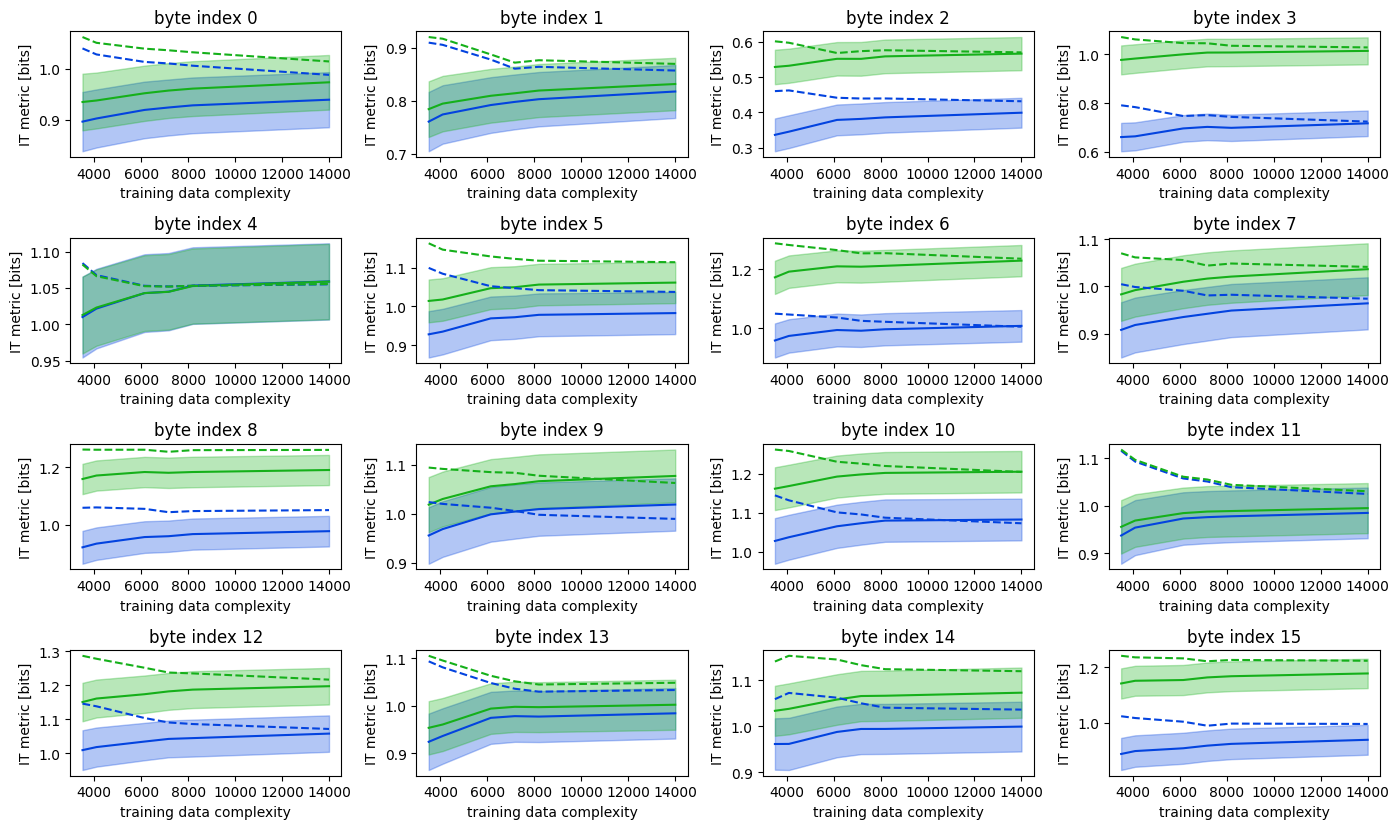

In [8]:
### Display
byte_indexes= range(16) # Elements in range [0; 15]. Bytes for which display the results.
test_scale.display_IT_results(
    byte_indexes, 
    [
        ("Univariate",results_pi_uni), 
        ("Multivariate", results_pi_multi),
        ("Univariate",results_ti_uni),
        ("Multivariate", results_ti_multi)
    ],
    scale=0.7,
    disable_legend=True
)

It turns out that PI/TI metrics are very useful tools when you want to explore the parameter set to find the values that maximize the information exploited. A very useful visual tool are heatmaps, which present the information results obtained for a range of parameters. Here, both PI and TI are displayed for each parameter set explored (respectively as a colored triangle in the bottom left and top right of each box). Try for yourself here! What can you see for a model that lack training traces? 

- *NB: the running time is ~1min per call to `utils_eval.explore_params`, don't hesitate to reduce the set of parameters to speed up the process*

In [19]:
from utils_scale import utils_eval
explo_npois = [8,16,64,256]
explo_ndims = [1,2,4,8]
explo_ntraces_pi = 2048

# Compute pi/ti
explo_params_bad = utils_eval.explore_params(pi_LDA_multi_TA, ti_LDA_multi_TA, ds['traces'], pSB, explo_ntraces_pi, explo_npois, explo_ndims, qp=4200)
explo_params = utils_eval.explore_params(pi_LDA_multi_TA, ti_LDA_multi_TA, ds['traces'], pSB, explo_ntraces_pi, explo_npois, explo_ndims)

progress:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 12/16 [00:11<00:03,  1.01it/s]/tmp/ipykernel_616665/722333736.py:11: RuntimeWarning: divide by zero encountered in log2
  return np.log2(models.predict_proba(traces.astype(np.int16)))
progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:41<00:00,  2.61s/it]


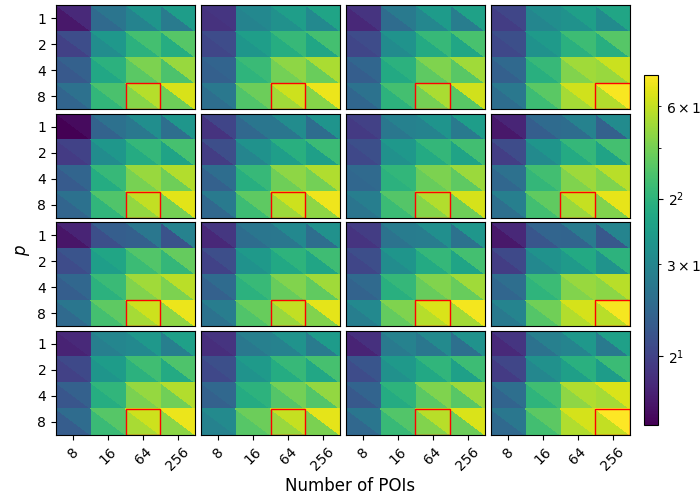

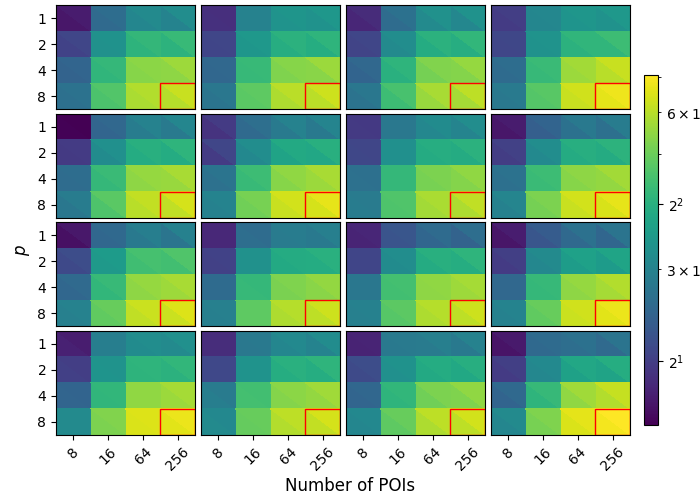

In [20]:
utils_eval.make_heatmap(explo_params_bad)
utils_eval.make_heatmap(explo_params)

## Histogram-based rank estimation

It turns out that you already used a common technique to evaluate the quality of different models in the last sections: mounting practical attacks based on the latter and evaluate the attack data complexity achieved! In general, template attacks allow to compute the probabilities $\hat{\boldsymbol{p}}_{k_i}$ that contains the probabilities associated to the different subkeys. In our previous examples, $i \in [0:15]$ and each $\hat{\boldsymbol{p}}_{k_i}$ is a vector of length 256 that contains the probabilities associated to every possible values taken by the byte subkey. 

If the correct subkey is always associated to the maximal probability for all subkeys, then the attack is directly successful and does not require to enumerate through potential key candidates. However, the situation may be different in practice, with some subkeys potentially proving more difficult to find than others for a given data complexity. Key enumeration algorithm allows to recombine the $\hat{\boldsymbol{p}}_{k_i}$ in order to list all the full key candidates from the most likely to the least likely with the aim of then testing the candidates exhaustively. With such a list, the attacks can be compared based on the position of the correct key in the list (denoted as the rank of the key). 

Computing the exact rank of a key turns out to be challenging since this approach is bounded by the enumeration power of the evaluator. To tackle the issue, rank estimation techniques are efficient algorithm that have been proposed to approximate the rank in an accurate manner. Next, we focus on the histogram-based rank estimation described in Section 2.5.1 and implemented by [SCALib](https://scalib.readthedocs.io/en/stable/source/api/scalib.postprocessing.rankestimation.html#module-scalib.postprocessing.rankestimation). 

We give you next the function `key_rank_approximation_scalib` that estimates the key rank using SCALib. Besides, the following piece of code compare the ranks obtained for the full 128-bit key between the univariate and the multivariate TA you implemented. Considering that you have access to a enumeration power of $2^{32}$, how much traces do you expect to recover the key with high probability using your univariate model? And with your multivariate model?  

In [11]:
from scalib.postprocessing import rank_accuracy
import numpy as np
def key_rank_approximation_scalib(subkey_probs, correct_subkeys, max_nb_bin=2**18):
    """
    subkey_probs: array of shape (nvars, 256), containing the probabilities associated to the values of 'nvars' subkey bytes.
    correct_subkeys: an array of shape  (nvars,), where the i-th element is the correct value of the i-th subkey. 
    return (rmin, r, rmax), where `r` is the approximated rank of the full key, `rmin` and `rmax` are respectively the minimal and maximal bounds.
    """
    return rank_accuracy(-np.log(subkey_probs), correct_subkeys, max_nb_bin=max_nb_bin)

In [12]:
from utils_scale import utils_files, utils_ta



## Run the TA from before
# Dataset used for the training
ds_train = utils_files.TRAINING_DS[0]

# Datasets on which perform the attack for comparions
ds_atcks = [utils_files.VALIDATION_DS[i] for i in range(5)]

# Attack complexities
qas = np.arange(1,20)

# LDAs params (overwrite here if 
# you want to use others valeus than the used configured for PI/TI metrics
onpois = npois
ondim = ndim

# Perform the attack
v_uTA = utils_ta.explore_TA_univariate(ds_train, ds_atcks, None, qas)
v_mTA = utils_ta.explore_TA_multivariate(ds_train, ds_atcks, None, qas, onpois, ondim)


Test: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:09<00:00,  9.52it/s]


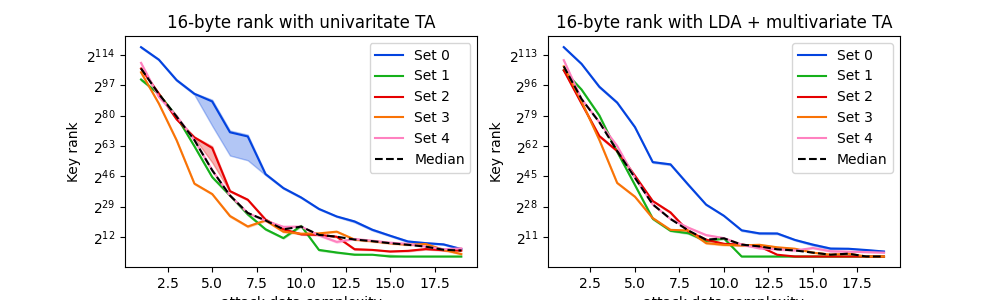

In [13]:
from utils_scale import utils_eval
%matplotlib widget
import matplotlib.pyplot as plt

byte_indexes = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
utils_eval.display_rank_esti_full_key(v_uTA, v_mTA, byte_indexes, key_rank_approximation_scalib)

## Summary question: Univariate Gaussian Template without pooling. 

You now have a set of tools and a good grasp of the concepts needed to answer the last question, which covers all the concepts we have covered in the various tutorials. In particular, how does a univariate TA model without pooling compare with the two models you have already used? What attack complexity can it achieve? For this question, we are volontarily not providing too much information in the template in order for you to go through the full evaluation process by yourself. To make things easier for you, we provide you the profiling phase implementation, which is implemented next. Don't hesitate to re-use part already implemented in the traing!! In particular, try to:

- Create a new function `pi_uni_TA_nopool` that is a tweaked implementation of `pi_uni_TA` relying on the new modeling phase (i.e., the function `univariate_gaussian_models_nopool`)
- Use `test_scale.compute_pi_estimations` in order to compute the PI values similarly to what was done at the beginning of the session, but using your new function `pi_uni_TA_nopool`.
- Use `test_scale.compute_ti_estimations` in order to compute the TI values similarly to what was done at the beginning of the session, but using your new function `pi_uni_TA_nopool`.
- Use `test_scale.display_IT_results` in order to display the IT metrics together with the other two!





In [14]:
import numpy as np
def univariate_gaussian_models_nopool(traces, classes, pois):
    """
    traces: the training traces, as an array of shape (ntraces, nsamples).
    classes: the label associated to each variables for every traces, as an array of shape  (ntraces, nvars)
    pois: the single POI kept for each variable, as an array of shape (nvars,)
    
    return: (us, ss), where `us` and `ss` are of shape (nvars, 256) and contain respectively 
    the mean and the standard deviation associated every classes of the different variables.
    """
    # Allocate return value
    us = np.zeros([classes.shape[1],256])
    ss = np.zeros([classes.shape[1],256])
    
    # Iterate over every variables
    for si in range(classes.shape[1]):
        # Iterate over all the possible bytes values
        for b in range(256):
            # Compute class mean
            us[si,b] = np.mean(traces[classes[:,si] == b, pois[si]])
            # Second, compute the pooled variance
            ss[si,b] = np.std(traces[classes[:,si] == b, pois[si]])
    # Return
    return (us, ss)


In [15]:

###ANSWER_START

# New function embedding the new profiling phase
def pi_uni_TA_nopool(train_trs, train_labels, test_trs, test_labels):
    """
    train_trs: the training traces as an array of shape (train_ntraces, nsamples)
    train_labels: training labels (train_ntraces, nvars)
    test_trs: the training traces as an array of shape (test_ntraces, nsamples)
    test_labels: test labels (test_ntraces, nvars)
    return: (pis, lprobs) where
        - `pis` is a vector of shape (nvars,) containing the PI computed for each variable
        - `lprobas` is a matrix of shape (nvars, test_ntraces) containing the log2 proba used to compute the PI
    """
    # SNR 
    pois = utils_ta.POI_selection_SNR(train_trs, train_labels, 256)
    # Compute the models
    models_uni = univariate_gaussian_models_nopool(train_trs, train_labels, pois[:,0])
    # Compute the log2prob
    log2prob = univariate_model_log2prob(test_trs, test_labels, pois[:,0], models_uni)
    # Compute the PI
    return compute_PI(test_labels, log2prob)

def ti_uni_TA_nopool(train_trs, train_labels):
    """
    train_trs: the training traces as an array of shape (train_ntraces, nsamples)
    train_labels: training labels (train_ntraces, nvars)
    return: (tis, lprobs) where
        - `tis` is a vector of shape (n_p,) containing the TI computed for each intermediate state
        - `lprobas` is a matrix of shape (n_p, nb_test) containing the log2 proba used to compute the TI for each of the `n_p' and for each trace.
    """
    return pi_uni_TA_nopool(train_trs, train_labels, train_trs.copy(), train_labels.copy())

# Compute the PI for the newunivariate model
results_pi_uni_new = test_scale.compute_pi_estimations(
    ds['traces'][:-amount_test_traces], 
    pSB[:-amount_test_traces], 
    ds['traces'][-amount_test_traces:], 
    pSB[-amount_test_traces:], 
    pi_uni_TA_nopool, 
    qt_s
)

# Compute the TI with the same configuration than the one used for the PI computation
results_ti_uni_new = test_scale.compute_ti_estimations(
    ds['traces'][:-amount_test_traces], 
    pSB[:-amount_test_traces], 
    ti_uni_TA_nopool, 
    qt_s
)

###ANSWER_STOP





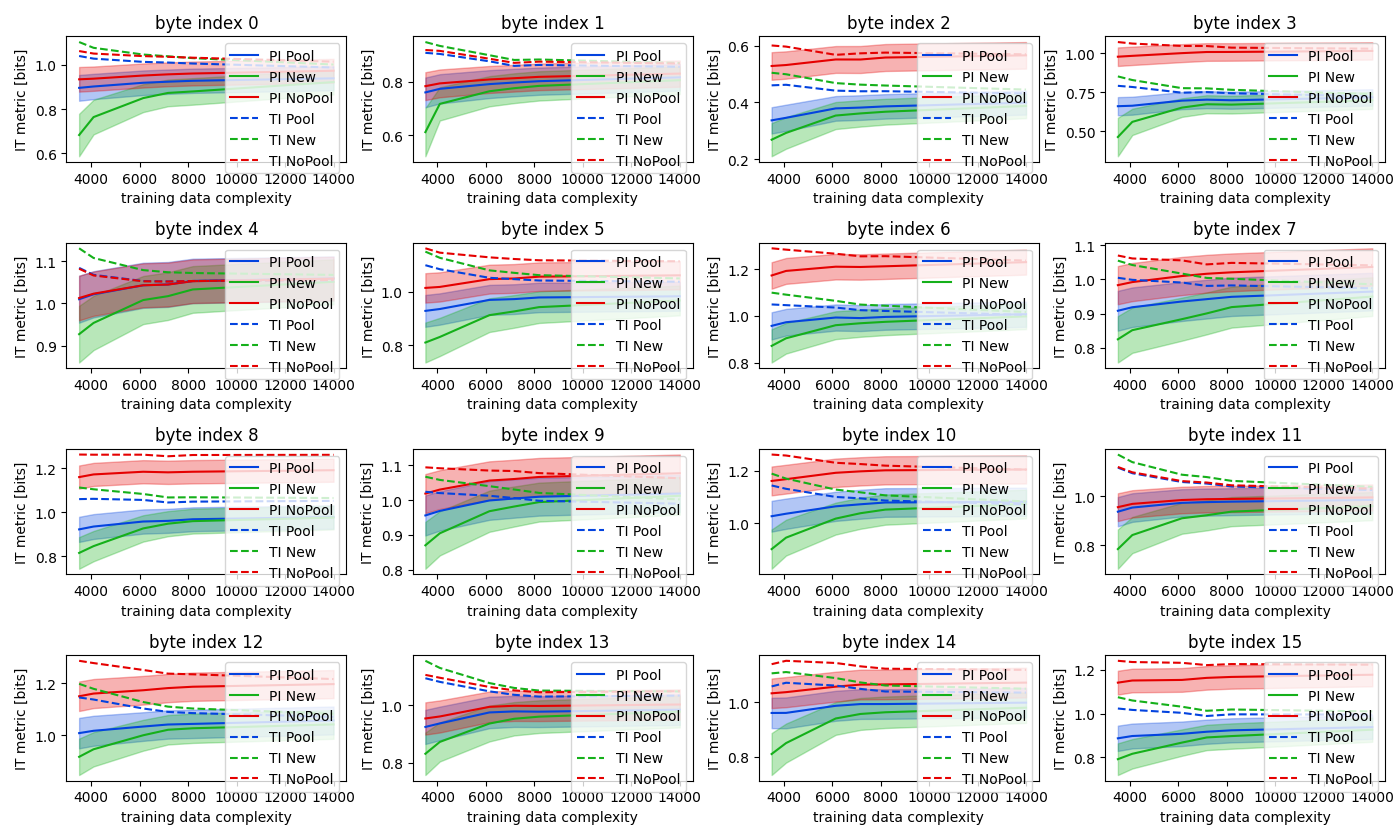

In [16]:
###ANSWER_START

# Display
byte_indexes= range(16) # Elements in range [0; 15]. Bytes for which display the results.
test_scale.display_IT_results(
    byte_indexes, 
    [
        ("Pool",results_pi_uni), 
        ("New",results_pi_uni_new), 
        ("NoPool", results_pi_multi),
        ("Pool",results_ti_uni),
        ("New",results_ti_uni_new),
        ("NoPool", results_ti_multi)
    ],
    scale=0.7,
    disable_legend=False
)

# Converge slower, but no big difference noticeable
###ANSWER_STOP

Additionnally, you can also compute the rank in a similar manner that what was done just above. In particular:

Test: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:13<00:00,  7.23it/s]


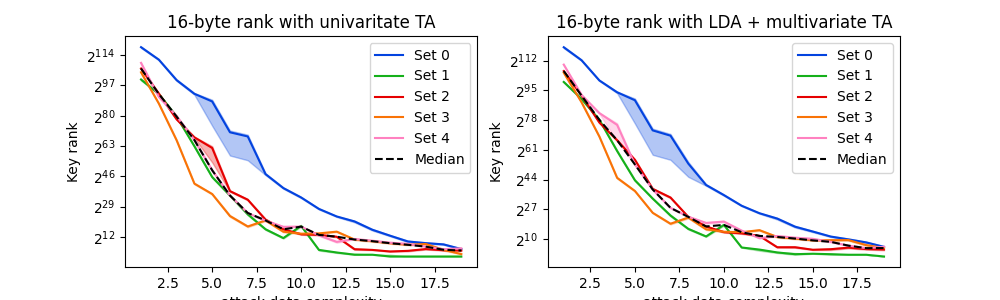

In [17]:
v_uTA_nopool = utils_ta.explore_TA_univariate(ds_train, ds_atcks, None, qas, fn_prof=univariate_gaussian_models_nopool)
from utils_scale import utils_eval
%matplotlib widget
import matplotlib.pyplot as plt

byte_indexes = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
utils_eval.display_rank_esti_full_key(v_uTA, v_uTA_nopool, byte_indexes, key_rank_approximation_scalib)